importing dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Add, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, InputLayer, GlobalAveragePooling2D ,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.rcParams['font.size'] = 14

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
img_size = 224
batch_size = 32


train_datagen = ImageDataGenerator(rescale = 1/255.,brightness_range=[0.5,1.5], zoom_range=0.2, 
                                   width_shift_range =0.15, height_shift_range =0.15, horizontal_flip=True )
val_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


train_generator = train_datagen.flow_from_directory('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=True,
                                                   class_mode='sparse')

val_generator = val_datagen.flow_from_directory('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='sparse')

test_generator = test_datagen.flow_from_directory('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode = "sparse")

Found 9957 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


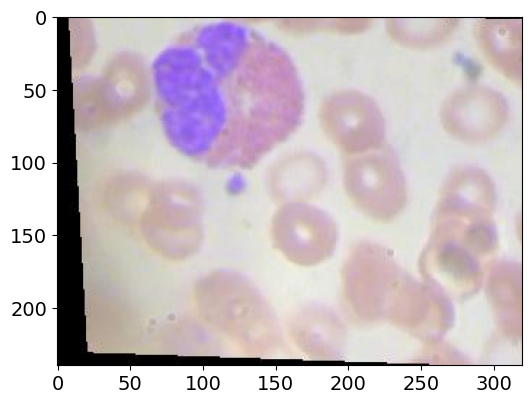

In [3]:
from glob import glob #retriving an array of files in directories
path_train = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL"
img = glob(path_train+"/*.jpeg")
# print(img)
img = np.asarray(plt.imread(img[15]))
plt.figure(figsize = (6, 6))
plt.imshow(img)
plt.show()

In [12]:
def residual_block(x, kernel_size, filters, s=2):
    f1,f2,f3 = filters
    x_shortcut = x
    
    # Shortcut Path
    x_shortcut = Conv2D(f3, kernel_size=(1,1), strides=(s,s), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    # Main Path
    # First Component
    x = Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Component
    x = Conv2D(f2, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third Component
    x = Conv2D(f3, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x

RESNET 50

In [13]:
input_layer = Input(shape=(224,224,3))
x = Conv2D(64, kernel_size=(7,7), strides=(2,2))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)

x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])

x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])

# x = residual_block(x,3,[512,512,2048])
# x = residual_block(x,3,[512,512,2048])
# x = residual_block(x,3,[512,512,2048])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
output_layer = Dense(4, activation='softmax')(x)

resnet50 = Model(inputs=input_layer,outputs=output_layer)

In [14]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 109, 109, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
# Uncomment to see the model as a figure
# tf.keras.utils.plot_model(resnet50,to_file='resnet50.png')

In [16]:
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [17]:
# loss = tf.keras.losses.sparse_categorical_crossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
resnet50.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
# Train the model
history = resnet50.fit(train_generator,
                        epochs=50,
                        validation_data=val_generator,
                        callbacks=[checkpoint,earlystopping])

Epoch 1/50
312/312 [==============================] - ETA: 0s - loss: 1.6888 - accuracy: 0.2522
Epoch 1: val_loss improved from inf to 1.45014, saving model to /tmp/checkpoint
312/312 [==============================] - 286s 800ms/step - loss: 1.6888 - accuracy: 0.2522 - val_loss: 1.4501 - val_accuracy: 0.1690
Epoch 2/50
312/312 [==============================] - ETA: 0s - loss: 1.5598 - accuracy: 0.2535
Epoch 2: val_loss improved from 1.45014 to 1.29678, saving model to /tmp/checkpoint
312/312 [==============================] - 167s 536ms/step - loss: 1.5598 - accuracy: 0.2535 - val_loss: 1.2968 - val_accuracy: 0.3662
Epoch 3/50
312/312 [==============================] - ETA: 0s - loss: 1.4821 - accuracy: 0.2688
Epoch 3: val_loss improved from 1.29678 to 1.16359, saving model to /tmp/checkpoint
312/312 [==============================] - 166s 532ms/step - loss: 1.4821 - accuracy: 0.2688 - val_loss: 1.1636 - val_accuracy: 0.6761
Epoch 4/50
312/312 [==============================] - ETA: 

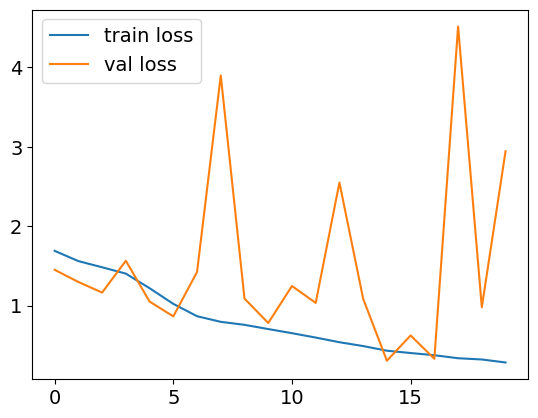

In [20]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

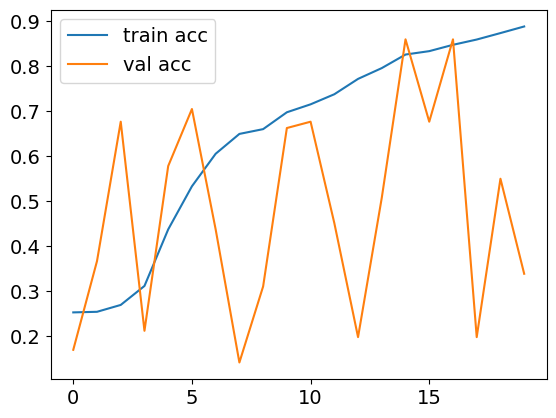

In [21]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [22]:
y_pred = resnet50.predict(test_generator).round()
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

78/78 [==============================] - 27s 341ms/step


In [23]:
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_test,y_pred,target_names = class_labels))

              precision    recall  f1-score   support

  EOSINOPHIL       0.88      0.74      0.80       623
  LYMPHOCYTE       0.98      1.00      0.99       620
    MONOCYTE       0.96      0.75      0.84       620
  NEUTROPHIL       0.65      0.88      0.75       624

    accuracy                           0.84      2487
   macro avg       0.87      0.84      0.85      2487
weighted avg       0.87      0.84      0.85      2487



In [24]:
print(accuracy_score(y_test, y_pred))

0.841978287092883


In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)